In [1]:
import networkx as nx
import numpy as np
from scipy.special import comb
from itertools import combinations 
import networkx.algorithms.isomorphism as iso
from tqdm import tqdm
import matplotlib.pyplot as plt
import dgl

In [2]:
def generate_graphlet(n):
    non_iso_graph = []
    non_iso_graph_adj = []
    dgl_graph = []
    for i in tqdm(range(n-1, int(comb(n, 2))+1)):
    # for each of these possible # of edges
        arr = np.array(range(int((n**2-n)/2)))
        all_comb = list(combinations(arr, i)) 
        # all possible combination of edge positions 
        indices = np.triu_indices(n, 1)
        for m in range(len(all_comb)):
            # iterate over all these graphs
            adj = np.zeros((n,n))
            adj[indices[0][np.array(all_comb[m])], indices[1][np.array(all_comb[m])]] = 1
            adj_temp = adj
            adj = adj + adj.T
            #print(adj)
            if sum(np.sum(adj_temp, axis = 0) == 0) == 1:
                #the graph has to be connected
                new_graph = nx.from_numpy_matrix(adj)
                if len(non_iso_graph) == 0:
                    non_iso_graph.append(new_graph)
                    non_iso_graph_adj.append(adj)
                    S = dgl.DGLGraph()
                    S.from_networkx(new_graph)
                    dgl_graph.append(S)
                else:
                    is_iso = False
                    for g in non_iso_graph:
                        if iso.is_isomorphic(g, new_graph):
                            #print('yes')
                            is_iso = True
                            break
                    if not is_iso:
                        # not isomorphic to any of the current graphs
                        non_iso_graph.append(new_graph)
                        non_iso_graph_adj.append(adj)
                        
                        S = dgl.DGLGraph()
                        S.from_networkx(new_graph)
                        dgl_graph.append(S)
                        
    
    print('There are {} non-isomorphic graphs'.format(len(non_iso_graph)))
    return dgl_graph
#for i in range(len(non_iso_graph)):
#    plt.figure(i+1)
#    nx.draw(non_iso_graph[i], with_labels = True)

In [19]:
graphs = []
for i in range(1, 5):
    graphs = graphs + generate_graphlet(i+1)

100%|██████████| 7/7 [00:00<00:00, 34.96it/s]

There are 1 non-isomorphic graphs
There are 2 non-isomorphic graphs
There are 6 non-isomorphic graphs
There are 21 non-isomorphic graphs


In [20]:
len(graphs)

30

In [22]:
(dgl.batch(graphs))

137

In [3]:
# borrow from OrbitalFeatures github
import pandas as pd
from tqdm import tqdm
import networkx as nx
from networkx.generators.atlas import *

class MotifCounterMachine(object):
    """
    Connected motif orbital role counter.
    """
    def __init__(self, graph, graphlet_size):
        """
        Creating an orbital role counter machine.
        :param graph: NetworkX graph.
        :param args: Arguments object.
        """
        self.graph = graph
        self.graphlet_size = graphlet_size

    def create_edge_subsets(self):
        """
        Enumerating connected subgraphs with size 2 up to the graphlet size.
        """
        print("\nEnumerating subgraphs.\n")
        self.edge_subsets = dict()
        subsets = [[edge[0], edge[1]] for edge in self.graph.edges()]
        self.edge_subsets[2] = subsets
        unique_subsets = dict()
        for i in range(3, self.graphlet_size+1):
            print("Enumerating graphlets with size: " +str(i) + ".")
            for subset in tqdm(subsets):
                for node in subset:
                    for neb in self.graph.neighbors(node):
                        new_subset = subset+[neb]
                        if len(set(new_subset)) == i:
                            new_subset.sort()
                            unique_subsets[tuple(new_subset)] = 1
            subsets = [list(k) for k, v in unique_subsets.items()]
            self.edge_subsets[i] = subsets
            unique_subsets = dict()

    def enumerate_graphs(self):
        """
        Creating a hash table of the benchmark motifs.
        """
        graphs = graph_atlas_g()
        self.interesting_graphs = {i: [] for i in range(2, self.graphlet_size+1)}
        for graph in graphs:
            if graph.number_of_nodes() > 1 and graph.number_of_nodes() < self.graphlet_size+1:
                if nx.is_connected(graph):
                    self.interesting_graphs[graph.number_of_nodes()].append(graph)

    def enumerate_categories(self):
        """
        Creating a hash table of benchmark orbital roles.
        """
        main_index = 0
        self.categories = dict()
        for size, graphs in self.interesting_graphs.items():
            self.categories[size] = dict()
            for index, graph in enumerate(graphs):
                self.categories[size][index] = dict()
                degrees = list(set([graph.degree(node) for node in graph.nodes()]))
                for degree in degrees:
                    self.categories[size][index][degree] = main_index
                    main_index = main_index + 1
        self.unique_motif_count = main_index + 1

    def setup_features(self):
        """
        Counting all the orbital roles.
        """
        print("\nCounting orbital roles.\n")
        self.features = {node: {i:0 for i in range(self.unique_motif_count)}for node in self.graph.nodes()}
        for size, node_lists in self.edge_subsets.items():
            graphs = self.interesting_graphs[size]
            for nodes in tqdm(node_lists):
                sub_gr = self.graph.subgraph(nodes)
                for index, graph in enumerate(graphs):
                    if nx.is_isomorphic(sub_gr, graph):
                        for node in sub_gr.nodes():
                            self.features[node][self.categories[size][index][sub_gr.degree(node)]] += 1
                        break

    def create_tabular_motifs(self):
        """
        Creating a table with the orbital role features.
        """
        print("Saving the dataset.")
        self.binned_features = {node: [] for node in self.graph.nodes()}
        self.motifs = [[n]+[self.features[n][i] for i in  range(self.unique_motif_count)] for n in self.graph.nodes()]
        self.motifs = pd.DataFrame(self.motifs)
        self.motifs.columns = ["id"] + ["role_"+str(index) for index in range(self.unique_motif_count)]
        #self.motifs.to_csv(self.args.output, index=None)

    def extract_features(self):
        """
        Executing steps for feature extraction.
        """
        self.create_edge_subsets()
        self.enumerate_graphs()
        self.enumerate_categories()
        self.setup_features()
        self.create_tabular_motifs()
        print('motif extracted')

In [19]:
G = nx.barabasi_albert_graph(30, 3)
m = MotifCounterMachine(G, 5)
m.extract_features()


100%|██████████| 81/81 [00:00<00:00, 34261.66it/s]

100%|██████████| 423/423 [00:00<00:00, 50453.31it/s]

100%|██████████| 2322/2322 [00:00<00:00, 39428.74it/s]

100%|██████████| 81/81 [00:00<00:00, 4320.29it/s]

  0%|          | 0/423 [00:00<?, ?it/s]


Enumerating subgraphs.

Enumerating graphlets with size: 3.
Enumerating graphlets with size: 4.
Enumerating graphlets with size: 5.

Counting orbital roles.




100%|██████████| 423/423 [00:00<00:00, 2669.75it/s]

100%|██████████| 2322/2322 [00:01<00:00, 1807.69it/s]

100%|██████████| 11768/11768 [00:11<00:00, 1046.39it/s]

Saving the dataset.
motif extracted


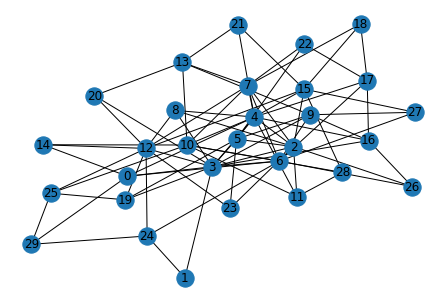

In [18]:
nx.draw(G, with_labels = True)

In [22]:
from sklearn.cluster import SpectralClustering
import numpy as np

X = m.motifs.values
clustering = SpectralClustering(n_clusters=5,
         assign_labels="discretize",
         random_state=0).fit(X)
clustering.labels_

/Users/kexinhuang/torch-env/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


array([1, 1, 2, 0, 2, 2, 1, 3, 2, 4, 3, 2, 1, 2, 3, 0, 4, 4, 3, 2, 1, 0,
       3, 4, 0, 1, 4, 4, 1, 3])